In [52]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/model_input_with_interactions.csv')


In [53]:
# Define full feature columns with interactions
feature_cols = [
    'gender_encoded',
    'age_group_encoded',
    'severity_encoded',
    'admission_encoded',
    'payment_type_encoded',
    'diagnosis_encoded',
    'procedure_encoded',
    'county_encoded',
    'los',
    'los_x_severity',
    'los_x_procedure',
    'severity_x_procedure',
    'los_x_county'
]

In [4]:
# Load saved models for each LOS group
model_short = joblib.load('../models/model_short.pkl')
model_moderate = joblib.load('../models/model_moderate.pkl')
model_long = joblib.load('../models/model_long.pkl')
model_extended = joblib.load('../models/model_extended.pkl')

## Define LOS Grouping Function

This function assigns each patient to a LOS category to route them to the correct model.

In [5]:
def get_los_group(los):
    if los <= 3:
        return 'short'
    elif los <= 14:
        return 'moderate'
    elif los <= 30:
        return 'long'
    else:
        return 'extended'

## Ensemble Prediction Function

This function uses the predicted LOS group to select the appropriate model and generate a charge prediction.

In [6]:
def ensemble_predict(df, feature_cols):
    df = df.copy()

    # Add LOS group label
    df['los_group'] = df['los'].apply(get_los_group)

    # Prepare output container
    preds = []

    # Loop through LOS groups and apply corresponding model
    for group, model in {
        'short': model_short,
        'moderate': model_moderate,
        'long': model_long,
        'extended': model_extended
    }.items():
        group_df = df[df['los_group'] == group]
        if not group_df.empty:
            X = group_df[feature_cols]
            y_pred_log = model.predict(X)
            y_pred = np.expm1(y_pred_log)  # Inverse log-transform
            preds.append(pd.Series(y_pred, index=group_df.index))

    # Combine all predictions
    df['ensemble_prediction'] = pd.concat(preds).sort_index()
    return df

## Evaluate Ensemble Model Performance

We apply the ensemble prediction to the full dataset and compare predicted vs. actual total charges.

In [7]:
# Apply the ensemble model
df_with_preds = ensemble_predict(df, feature_cols)

# Evaluate performance
y_true = df_with_preds['total_charges']
y_pred = df_with_preds['ensemble_prediction']
mae_ensemble = mean_absolute_error(y_true, y_pred)

print(f"Ensemble MAE: ${mae_ensemble:,.2f}")

Ensemble MAE: $15,492.15


In [ ]:
# df_with_preds[['total_charges', 'ensemble_prediction']].to_csv(
#     '../data/predictions_with_ensemble.csv', index=False


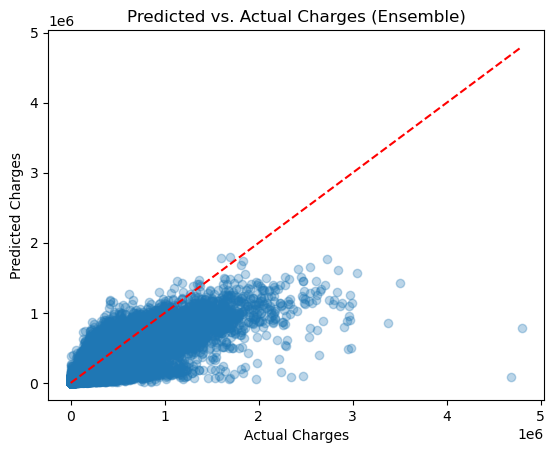

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--')  # perfect line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs. Actual Charges (Ensemble)")
plt.show()

## Identify and Isolate Worst-Case Residuals

In [9]:
# Create residuals column
df_with_preds['residual'] = abs(df_with_preds['ensemble_prediction'] - df_with_preds['total_charges'])

# Sort and extract worst 2,500 residuals
worst_2500 = df_with_preds.sort_values(by='residual', ascending=False).head(2500)

# worst_2500.to_csv('../data/ensemble_worst_2500_residuals.csv', index=False)

### Load Mapping Files

In [10]:
worst_2500 = pd.read_csv('../data/ensemble_worst_2500_residuals.csv')

# Load mapping tables
proc_map = pd.read_csv('../data/procedure_mapping.csv')
county_map = pd.read_csv('../data/county_mapping.csv')
age_map = pd.read_csv('../data/age_group_mapping.csv')
gender_map = pd.read_csv('../data/gender_mapping.csv')
severity_map = pd.read_csv('../data/severity_mapping.csv')
admit_map = pd.read_csv('../data/admission_type_mapping.csv')
payment_map = pd.read_csv('../data/payment_type_mapping.csv')
diag_map = pd.read_csv('../data/diagnosis_mapping.csv')

### Merge All Mappings

In [12]:
# Merge step-by-step
labeled = (
    worst_2500
    .merge(proc_map, on='procedure_encoded', how='left')
    .merge(county_map, on='county_encoded', how='left')
    .merge(age_map, on='age_group_encoded', how='left')
    .merge(gender_map, on='gender_encoded', how='left')
    .merge(severity_map, on='severity_encoded', how='left')
    .merge(admit_map, on='admission_encoded', how='left')
    .merge(payment_map, on='payment_type_encoded', how='left')
    .merge(diag_map, on='diagnosis_encoded', how='left')
)


In [13]:
labeled[['total_charges', 'ensemble_prediction', 'residual', 
         'ccs_procedure_description', 'hospital_county', 'age_group', 
         'gender', 'severity', 'admission_type', 'payment_type']].head()


,total_charges,ensemble_prediction,residual,ccs_procedure_description,hospital_county,age_group,gender,severity,admission_type,payment_type
0,4687203.67,91254.953286,4.595949e+06,PERC TRANSLUM COR ANGIO,Nassau,70 or Older,M,Major,Emergency,Medicare
1,4795125.93,780762.787798,4.014363e+06,ELECTROENCEPHALOGRAM,Manhattan,0 to 17,M,Major,Emergency,Private Health Insurance
2,3374148.52,857256.353396,2.516892e+06,UP GASTRO ENDOSC/BIOPSY,Westchester,18 to 29,M,Extreme,Elective,Private Health Insurance
3,2981283.62,498942.368545,2.482341e+06,COLORECTAL RESECTION,Manhattan,50 to 69,M,Minor,Urgent,Medicaid
4,2953401.10,490709.387858,2.462692e+06,OTHER OR THER NERV SYS,Manhattan,0 to 17,M,Minor,Emergency,Other


### High-Error Procedures
Goal: Find which procedures consistently have the highest prediction errors.

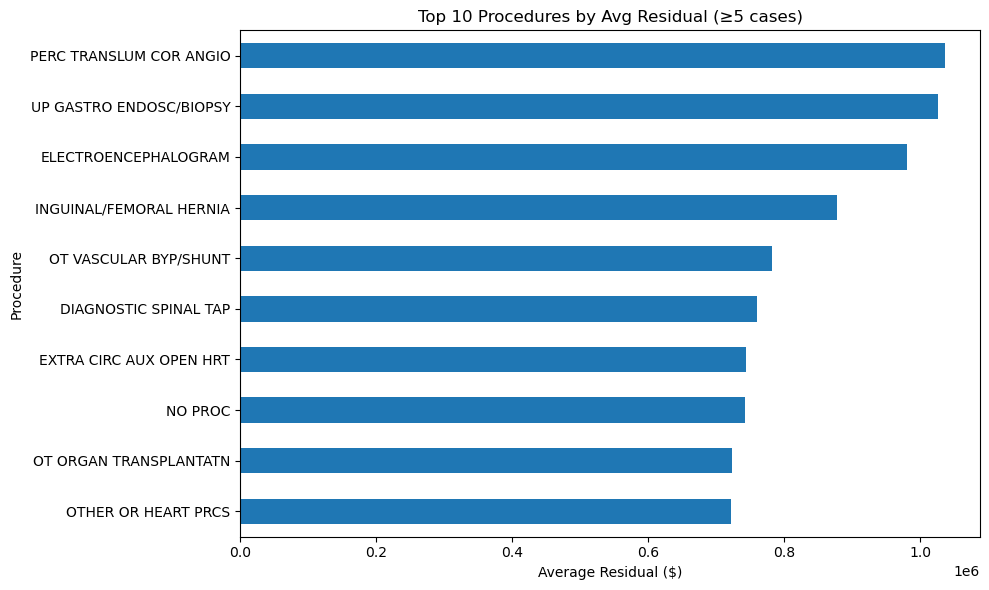

In [14]:
proc_residuals = (
    labeled.groupby('ccs_procedure_description')
    .agg(avg_residual=('residual', 'mean'), count= ('residual', 'size'))
    .query('count >= 5')  # Only include procedures with 5+ cases
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

# Plot it 
proc_residuals['avg_residual'].sort_values().plot.barh(figsize=(10, 6))
plt.title('Top 10 Procedures by Avg Residual (≥5 cases)')
plt.xlabel('Average Residual ($)')
plt.ylabel('Procedure')
plt.tight_layout()
plt.show()


This chart shows the **top 10 procedures** with the highest average residuals among the 2,500 worst-predicted cases (only procedures with ≥5 occurrences included).

- **PERC TRANSLUM COR ANGIO** and **UP GASTRO ENDOSC/BIOPSY** had the largest underpredictions, with average residuals close to $1 million.

- Several high-error procedures, such as **ELECTROENCEPHALOGRAM** and **INGUINAL/FEMORAL HERNIA**, are common but variable in cost, possibly due to differences in setting (e.g., emergency vs. outpatient).

- **NO PROC** appearing in the top 10 suggests that missing or unrecorded procedures may confuse the model.



## County-Level Residuals
Goal: Identify regional/hospital-related patterns

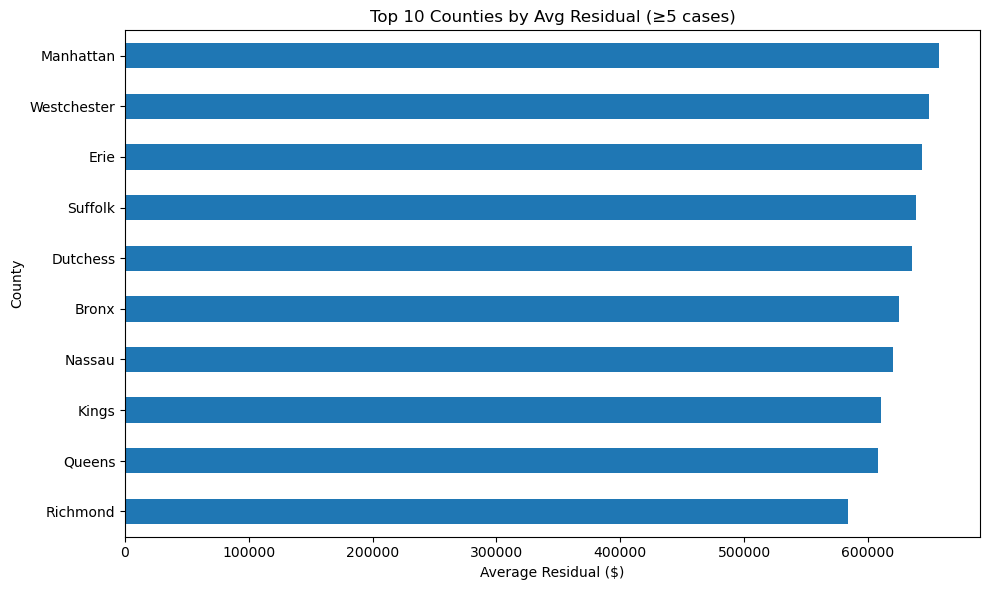

In [15]:
county_residuals = (
    labeled.groupby('hospital_county')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

county_residuals['avg_residual'].sort_values().plot.barh(figsize=(10, 6))
plt.title('Top 10 Counties by Avg Residual (≥5 cases)')
plt.xlabel('Average Residual ($)')
plt.ylabel('County')
plt.tight_layout()
plt.show()


This plot shows the **top 10 hospital counties** with the highest average residuals among the worst 2,500 predictions

- **Manhattan** and **Westchester** have the largest average errors, suggesting potential regional variability in cost structures.

- **All five** NYC boroughs (Manhattan, Bronx, Queens, Kings, Richmond) appear in the top 10, which may reflect urban hospital complexity, teaching hospital outliers, or billing practices.

**Takeaway:** Model performance could be improved by explicitly accounting for regional cost variation, or by building region-aware models.



## Residuals by Severity & LOS Group
Goal: See if model underperforms for complex/severe patients

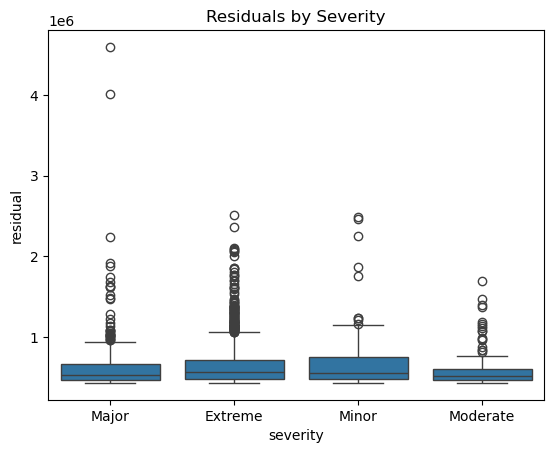

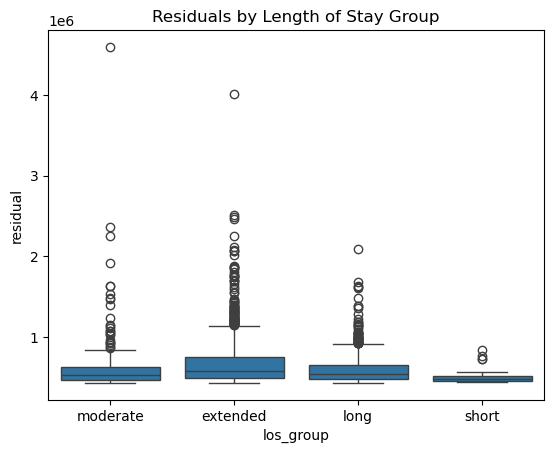

In [16]:
sns.boxplot(x='severity', y='residual', data=labeled)
plt.title("Residuals by Severity")
plt.show()

sns.boxplot(x='los_group', y='residual', data=labeled)
plt.title("Residuals by Length of Stay Group")
plt.show()


These boxplots show the distribution of **residuals** across patient **severity levels** and **LOS** groups.

- **Extreme** and **Major** cases show wider spread and more high-value outliers, indicating that the model struggles with more complex or costly patient types.

- Similarly, **Extended** and **Long** LOS groups have substantially more extreme residuals compared to Short stays.

- **Short** stays show the tightest and most **accurate** predictions, suggesting the model is more reliable for low-complexity, low-cost cases.

## Interaction Feature - los_x_severity
**Goal:** Evaluate whether adding an interaction feature between **Length of Stay (LOS)** and **Severity** improves the model’s ability to capture complex patient charge patterns.


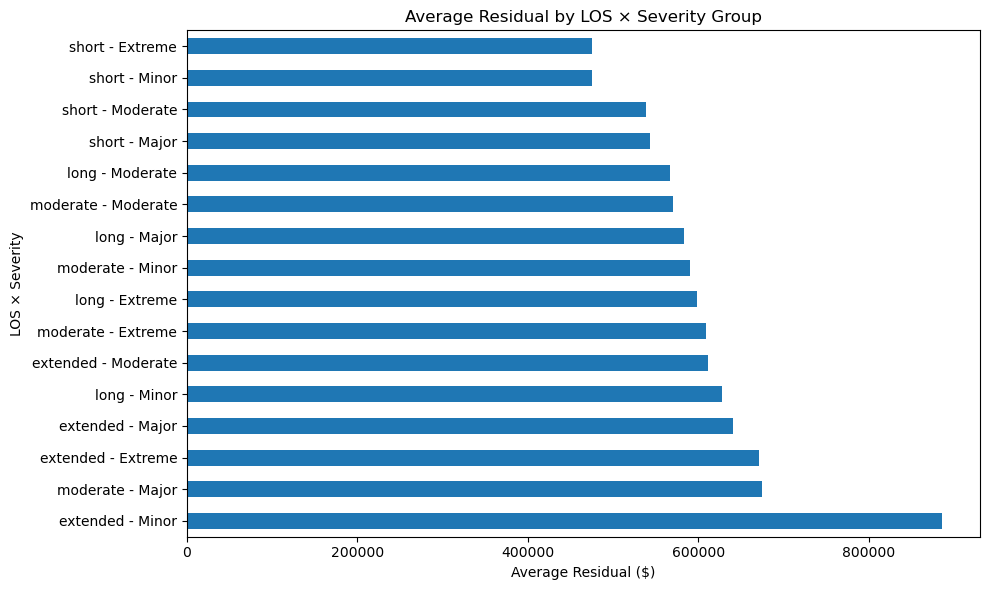

In [18]:
# Create readable labels for each LOS × Severity group
labeled["los_severity_label"] = labeled["los_group"] + " - " + labeled["severity"]

# Group by label and compute mean residual
grouped_los_sev = (
    labeled.groupby("los_severity_label")
    .agg(avg_residual=("residual", "mean"), count=("residual", "size"))
    .query('count >= 5')
    .sort_values(by="avg_residual", ascending=False)
)

# Bar plot
fig, ax = plt.subplots(figsize=(10, 6))
grouped_los_sev["avg_residual"].plot.barh(ax=ax)
ax.set_title("Average Residual by LOS × Severity Group")
ax.set_xlabel("Average Residual ($)")
ax.set_ylabel("LOS × Severity")
plt.tight_layout()
plt.show()


This bar chart breaks down **model residuals** by combinations of **Length of Stay (LOS)** and **Severity** levels.

- Each group (e.g., **"extended - Minor"**, **"short - Major"**) represents patients with similar clinical complexity and stay duration.
- Residuals are calculated as the absolute error between the model’s prediction and actual total charges.

**Key Insight:**
- The group **"extended - Minor"** stands out with the **highest average residual**, suggesting the model struggles most with this unexpected combination — **minor severity** but **very long hospital stay**.
- Residuals increase consistently with **LOS**, especially for **extended stay** groups, regardless of severity.



## Residuals by Diagnoses


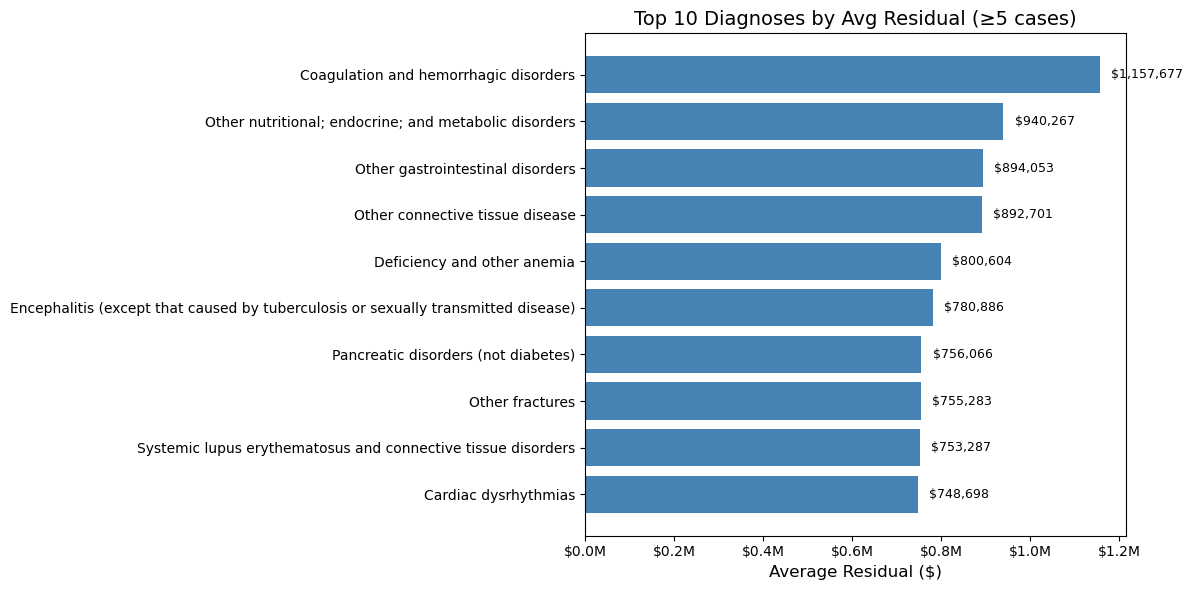

In [19]:
diagnoses_residuals = (
    labeled.groupby('ccs_diagnosis_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

import matplotlib.ticker as ticker

# Sort values for plotting
sorted_diagnoses = diagnoses_residuals['avg_residual'].sort_values() 
fig, ax = plt.subplots(figsize=(12, 6)) # Set up figure
bars = ax.barh(sorted_diagnoses.index, sorted_diagnoses.values, color='steelblue') # Bar plot
# Format x-axis to show dollar values in millions
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')) 

# Add value labels to end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 25000, bar.get_y() + bar.get_height() / 2,
            f'${width:,.0f}', va='center', fontsize=9, color='black')

# Titles and labels
ax.set_title('Top 10 Diagnoses by Avg Residual (≥5 cases)', fontsize=14)
ax.set_xlabel('Average Residual ($)', fontsize=12)

# Tight layout with less left margin
plt.subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()


This chart shows the **10 diagnosis categories** with the **highest average prediction errors** in the model’s worst 2,500 cases (limited to groups with **≥5 records**).

- **Coagulation and hemorrhagic disorders** had the **largest average residual**, over **$1.1M**.
- Several categories involving **immune**, **endocrine**, and **gastrointestinal** disorders appear frequently.
- Diagnoses with **high clinical complexity** or **variable treatment patterns** are more likely to be underpredicted.

**Takeaway:** These diagnoses may benefit from better modeling of cost drivers like **length of stay**, **procedure type**, or **admission context**. They're strong candidates for **SHAP analysis** or targeted model improvement.

##  Residuals by Payment Type

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_5782/2285980083.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pay_residuals.index, rotation=30, ha='right')


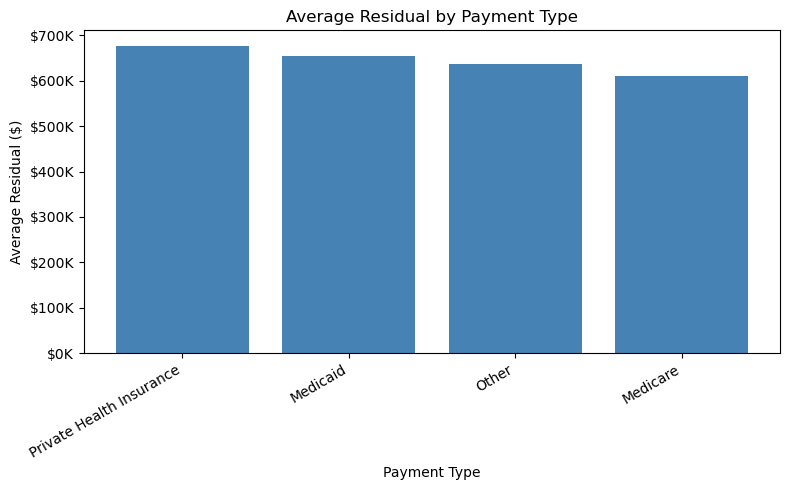

In [20]:
# Group and sort
pay_residuals = (
    labeled.groupby('payment_type')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .sort_values(by='avg_residual', ascending=False)
)

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars
bars = ax.bar(pay_residuals.index, pay_residuals['avg_residual'], color='steelblue')

# Format y-axis to $100K units
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e3:.0f}K'))

# Axis labels and title
ax.set_title('Average Residual by Payment Type')
ax.set_xlabel('Payment Type')
ax.set_ylabel('Average Residual ($)')
ax.set_xticklabels(pay_residuals.index, rotation=30, ha='right')
plt.tight_layout()
plt.show()


## SHAP Explainability on High-Error Groups

In [21]:
model = joblib.load('../models/model_extended.pkl')

 Filter the target group

In [27]:
target_group = labeled[labeled['ccs_diagnosis_description'] == 'Septicemia (except in labor)']

 Select only the model input columns

In [28]:
model_input_cols = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county'
]
X = target_group[model_input_cols]

In [29]:
# Load SHAP explainer
import shap
explainer = shap.TreeExplainer(model)

In [ ]:
# Compute SHAP values
shap_values = explainer.shap_values(X)

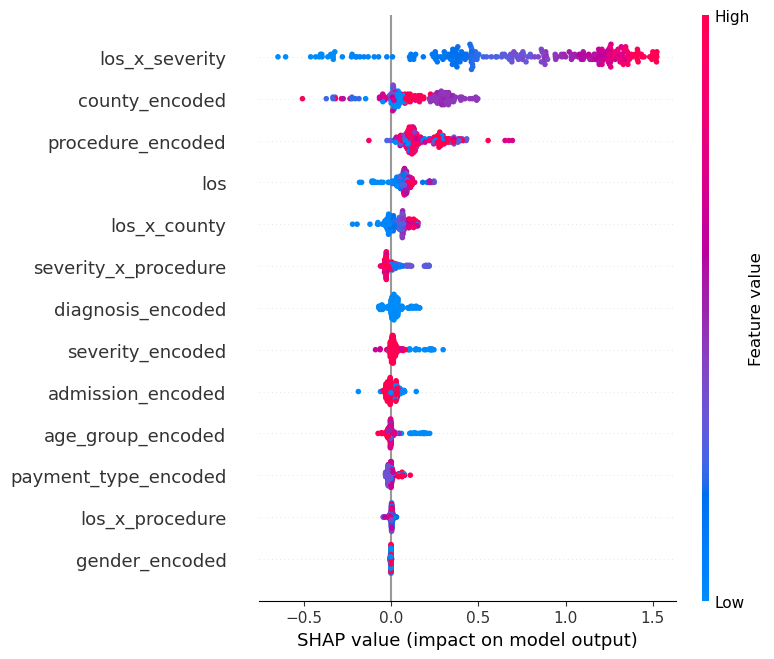

In [31]:
# Plot SHAP summary
shap.summary_plot(shap_values, X)

### SHAP Summary for Septicemia Cases

- **LOS × Severity** had the highest SHAP impact, indicating the model depends heavily on how long and how sick patients are.
- However, high values (red) were sometimes associated with **underprediction**, suggesting that even extreme patients are underestimated.
- **County** plays a surprisingly large role, with wide variability — some counties appear to be strong cost drivers not fully captured by the model.
- **Procedure** and **LOS** were major contributors, while **age**, **gender**, and **payment type** had little impact in these cases.

➡️ **Implication:** Consider engineering new features combining county, severity, and procedures, or building a dedicated sub-model just for Septicemia cases.

## SHAP for Extended - Minor

In [37]:
model_input_columns = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded', 
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded', 
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county'
]

In [35]:
target_group = labeled[
    (labeled['los_group'] == 'extended') & 
    (labeled['severity'] == 'Minor')
]

In [38]:
explainer = shap.Explainer(model)

# Prepare input data
X = target_group[model_input_columns]

# Generate SHAP values
shap_values = explainer(X)

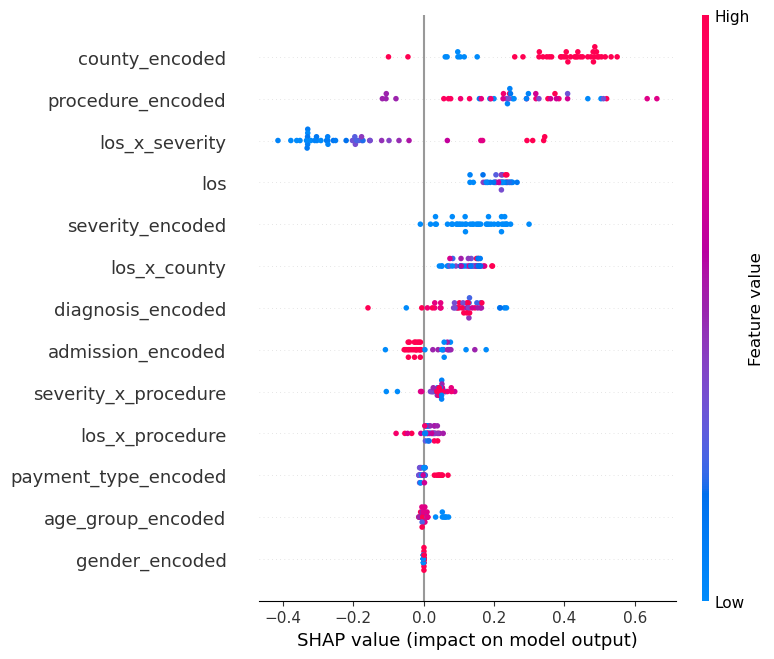

In [39]:
shap.summary_plot(shap_values, X)


- **County** and **Procedure** were the top contributors to prediction variance, suggesting that **regional cost variations** and **procedure mix** play a large role even in “minor” cases.
- **LOS × Severity** had a visible impact, but the model may still **underpredict rare combinations** like long stays with low-coded severity.
- The plot confirms that **low-severity, long-stay patients** are underrepresented or misunderstood by the model’s logic.

 ## Extended-Major Group

In [40]:
target_group = labeled[
    (labeled['los_group'] == 'extended') & 
    (labeled['severity'] == 'Major')
]

In [43]:
# groupby within this subset
(
    target_group
    .groupby('ccs_procedure_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

,avg_residual,count
ccs_procedure_description,,
ELECTROENCEPHALOGRAM,1.469753e+06,5
OTHER OR HEART PRCS,1.074832e+06,5
OT OR PRCS VES NOT HEAD,7.942738e+05,8
OT ORGAN TRANSPLANTATN,7.679067e+05,10
BONE MARROW TRANSPLANT,7.079644e+05,15
TRACHEOSTOMY; TEMP/PERM,6.810084e+05,8
OTHER THERAPEUTIC PRCS,5.959643e+05,16
RESP INTUB/MECH VENTIL,5.904826e+05,64
HEART VALVE PRCS,5.771366e+05,7


| Procedure Description         | Avg Residual ($) | Count |
|------------------------------|------------------|--------|
| ELECTROENCEPHALOGRAM         | 1,469,753        | 5      |
| OTHER OR HEART PRCS          | 1,074,832        | 5      |
| OT OR PRCS VES NOT HEAD      | 794,274          | 8      |
| OT ORGAN TRANSPLANTATN       | 767,907          | 10     |
| BONE MARROW TRANSPLANT       | 707,964          | 15     |
| TRACHEOSTOMY; TEMP/PERM      | 681,008          | 8      |
| OTHER THERAPEUTIC PRCS       | 595,964          | 16     |
| RESP INTUB/MECH VENTIL       | 590,483          | 64     |
| HEART VALVE PRCS             | 577,137          | 7      |
| ENTERAL/PARENTERAL NUTR      | 514,278          | 8      |

In [44]:
# Subset each procedure
top_procs = ['ELECTROENCEPHALOGRAM', 'BONE MARROW TRANSPLANT', 'TRACHEOSTOMY; TEMP/PERM']

for proc in top_procs:
    subset = labeled[labeled['ccs_procedure_description'] == proc]

X = subset[model_input_cols]
shap_values = explainer(X)

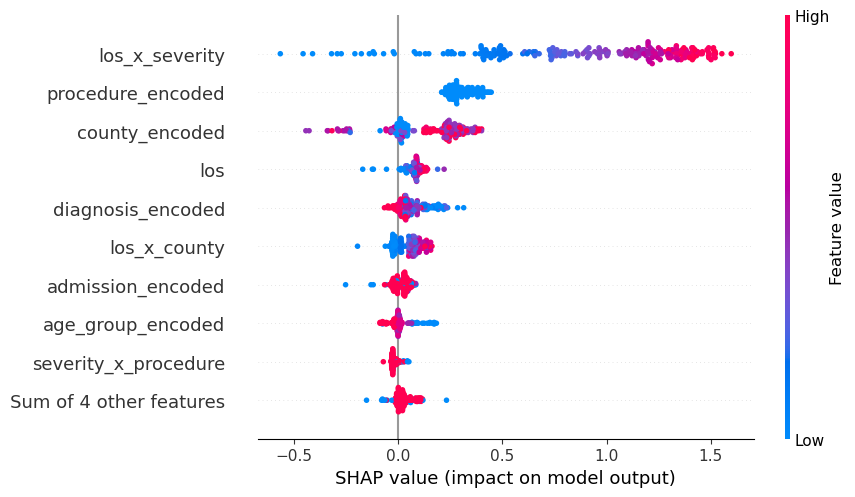

In [45]:
shap.plots.beeswarm(shap_values, max_display=10)

- **`los_x_severity`** is the strongest contributor to model output, indicating this interaction needs better calibration.
- **`procedure_encoded`** itself has significant impact, but not enough to fully correct for this procedure’s actual cost.
- **Counties** and **diagnosis codes** also influence predictions, suggesting there may be location- or condition-specific charge patterns.
- Model may be **underestimating patients** with high LOS × Severity combinations, especially for this procedure.

#### ELECTROENCEPHALOGRAM

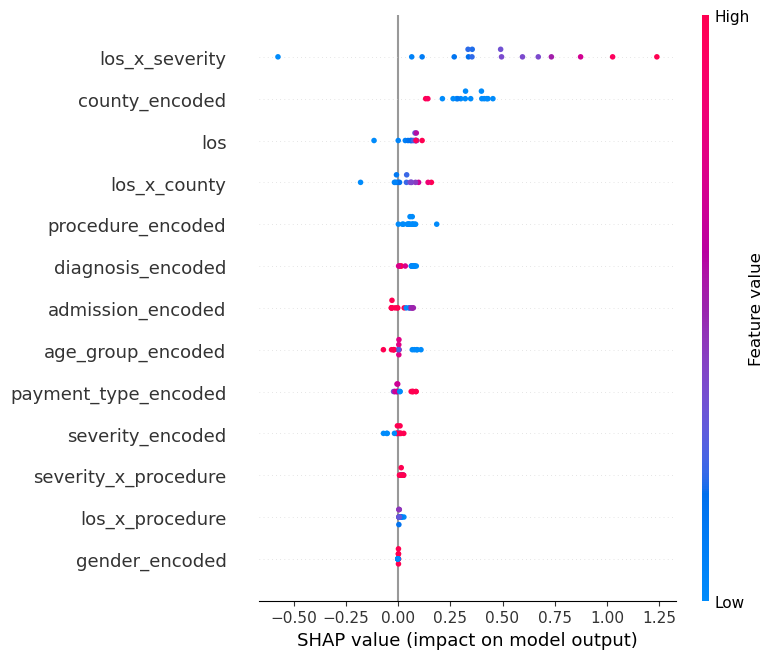

In [ ]:
target_group = labeled[labeled['ccs_procedure_description'] == 'ELECTROENCEPHALOGRAM']
shap_values = explainer(target_group[model_input_columns])
shap.summary_plot(shap_values, target_group[model_input_columns])

#### BONE MARROW TRANSPLANT

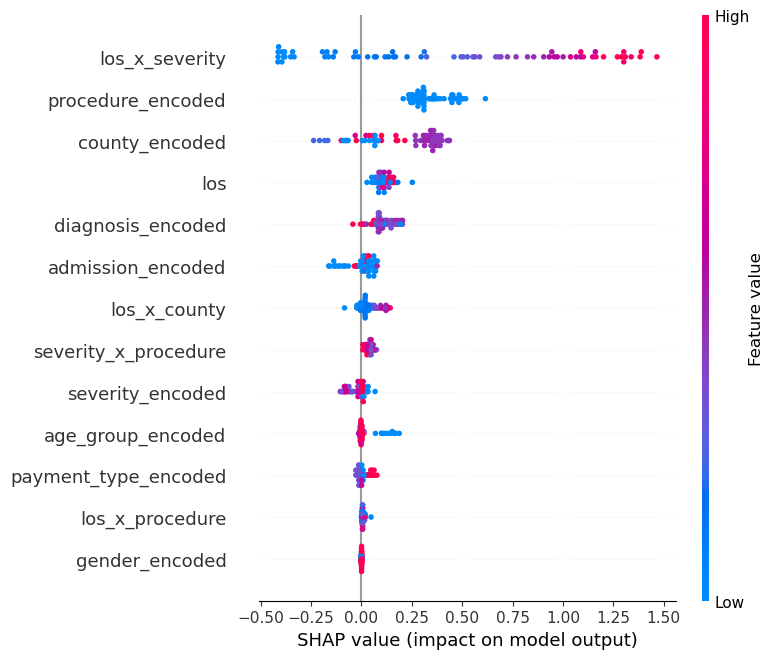

In [48]:
target_group = labeled[labeled['ccs_procedure_description'] == 'BONE MARROW TRANSPLANT']
shap_values = explainer(target_group[model_input_columns])
shap.summary_plot(shap_values, target_group[model_input_columns])

#### TRACHEOSTOMY; TEMP/PERM

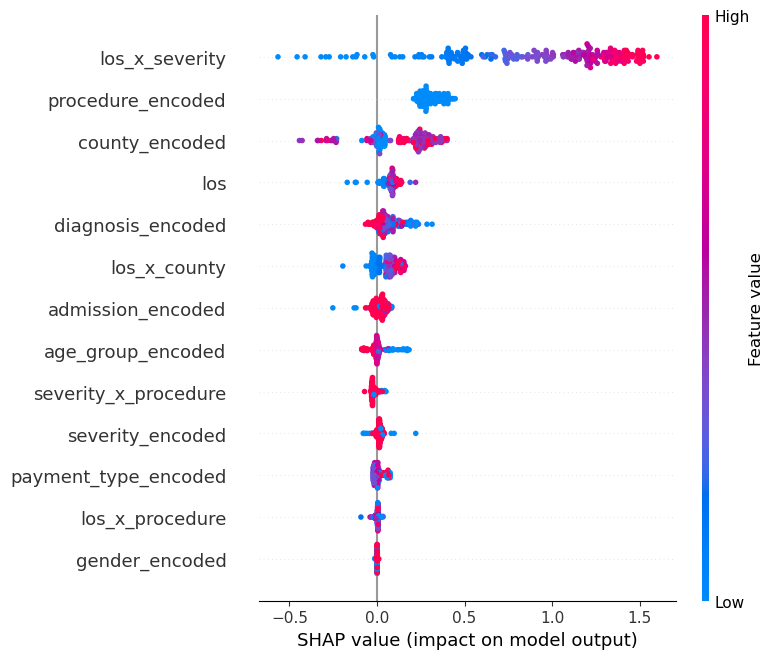

In [49]:
target_group = labeled[labeled['ccs_procedure_description'] == 'TRACHEOSTOMY; TEMP/PERM']
shap_values = explainer(target_group[model_input_columns])
shap.summary_plot(shap_values, target_group[model_input_columns])